# Investigate the augmented trajectories

## Analyze the `round_table` augmentation

### Qualitatively analyze trajectories

In [23]:
from pathlib import Path
from src.visualization.render_mp4 import (
    mp4_from_pickle_jupyter,
    unpickle_data,
    pickle_data,
)
from src.common.files import get_raw_paths
import random
from tqdm import tqdm

base_dir = Path("tmp")

In [22]:
paths = get_raw_paths(
    environment="sim",
    demo_source="augmentation",
    demo_outcome="success",
    task="round_table",
    randomness="low",
)

random.shuffle(paths)

len(paths), paths[:3]

Found the following paths:
    /data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/round_table/augmentation/low/success/*.pkl*


(514,
 [PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/round_table/augmentation/low/success/2024-02-17T22:04:17.pkl.xz'),
  PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/round_table/augmentation/low/success/2024-02-17T22:43:48.pkl.xz'),
  PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/round_table/augmentation/low/success/2024-02-17T20:29:26.pkl.xz')])

In [24]:
for path in paths[:5]:
    mp4_from_pickle_jupyter(path, filename=(base_dir / path.stem).with_suffix(".mp4"), fps=20)

File saved as tmp/2024-02-17T22:04:17.mp4


File saved as tmp/2024-02-17T22:43:48.mp4


File saved as tmp/2024-02-17T20:29:26.mp4


File saved as tmp/2024-02-17T20:34:04.mp4


File saved as tmp/2024-02-17T21:13:40.mp4


### Plot coverage of new trajectories

In [25]:
import zarr
import matplotlib.pyplot as plt
import numpy as np


from src.common.files import get_processed_paths

In [26]:
aug_path, teleop_path = sorted(
    get_processed_paths(
        environment="sim",
        demo_source=["teleop", "augmentation"],
        demo_outcome="success",
        task="round_table",
        randomness="low",
    )
)

aug_path, teleop_path

Found the following paths:
    /data/scratch/ankile/furniture-data/processed/sim/round_table/teleop/low/success.zarr
    /data/scratch/ankile/furniture-data/processed/sim/round_table/augmentation/low/success.zarr


(PosixPath('/data/scratch/ankile/furniture-data/processed/sim/round_table/augmentation/low/success.zarr'),
 PosixPath('/data/scratch/ankile/furniture-data/processed/sim/round_table/teleop/low/success.zarr'))

In [27]:
z_aug = zarr.open(str(aug_path), mode="r")
z_teleop = zarr.open(str(teleop_path), mode="r")

ends_aug = z_aug["episode_ends"][:]
ends_teleop = z_teleop["episode_ends"][:]

pos_teleop = z_teleop["robot_state"][:, :3]
pos_aug = z_aug["robot_state"][:, :3]

# Split the data into episodes
pos_teleop = np.split(pos_teleop, ends_teleop[:-1])
pos_aug = np.split(pos_aug, ends_aug[:-1])

# # Concat them together again
pos_teleop = np.concatenate(pos_teleop)
pos_aug = np.concatenate(pos_aug)

In [28]:
len(ends_teleop), len(pos_teleop), len(ends_aug), len(pos_aug)

(50, 47246, 500, 28105)

### Plot the state-space coverage in 3D

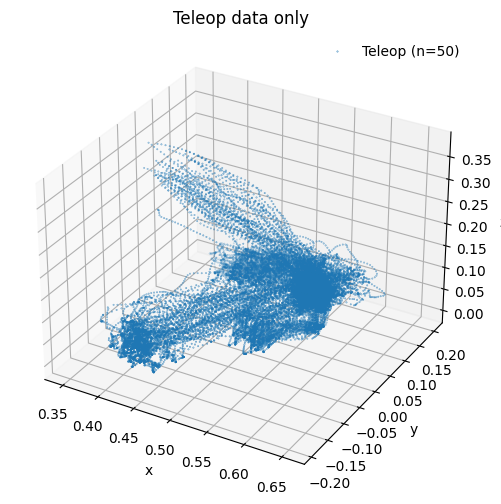

In [29]:
fig = plt.figure(figsize=(6, 6))

# Add a subplot for teleop data in the left side of the figure
ax1 = fig.add_subplot(
    111, projection="3d"
)  # Changed from 111 to 121 for a 1x2 grid, first position
ax1.scatter(*pos_teleop.T, label=f"Teleop (n={len(ends_teleop)})", s=0.1)
ax1.legend(frameon=False)
ax1.set_title("Teleop data only")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

plt.show()

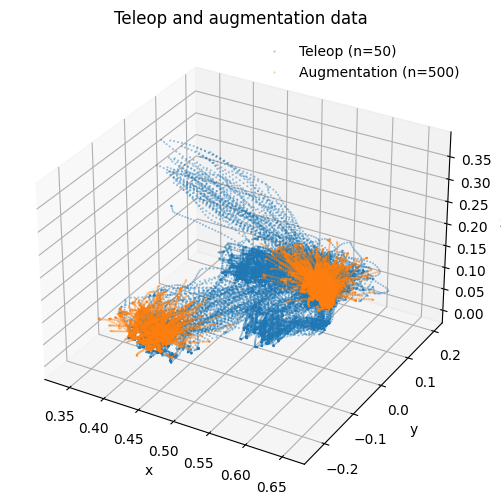

In [30]:
fig = plt.figure(figsize=(6, 6))

# Add a subplot for augmentation data in the right side of the figure
ax2 = fig.add_subplot(
    111, projection="3d"
)  # Changed from 111 to 122 for a 1x2 grid, second position
ax2.scatter(*pos_teleop.T, label=f"Teleop (n={len(ends_teleop)})", s=0.2, alpha=0.5)
ax2.scatter(*pos_aug.T, label=f"Augmentation (n={len(ends_aug)})", s=0.2, alpha=0.5)
ax2.legend(frameon=False)
ax2.set_title("Teleop and augmentation data")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")

plt.savefig("figs/teleop_augmentation.png")

plt.show()

## Analyze the `lamp` augmentation

### Qualitatively analyze trajectories

In [21]:
from pathlib import Path
from src.visualization.render_mp4 import (
    mp4_from_pickle_jupyter,
    unpickle_data,
    pickle_data,
)
from src.common.files import get_raw_paths
import random
from tqdm import tqdm

In [22]:
paths = get_raw_paths(
    environment="sim",
    demo_source="augmentation",
    demo_outcome="success",
    task="lamp",
    randomness="low",
)

random.shuffle(paths)

len(paths), paths[:3]

Found the following paths:
    /data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/lamp/augmentation/low/success/*.pkl*


(542,
 [PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/lamp/augmentation/low/success/2024-02-19T16:43:14.pkl.xz'),
  PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/lamp/augmentation/low/success/2024-02-19T19:06:43.pkl.xz'),
  PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/lamp/augmentation/low/success/2024-02-19T20:19:27.pkl.xz')])

In [23]:
for p in tqdm(paths):
    path = Path(p)
    try:
        data = unpickle_data(path)
    except EOFError:
        print(f"Failed to load {path}")

100%|██████████| 542/542 [01:22<00:00,  6.58it/s]


In [24]:
for path in paths[:25]:
    mp4_from_pickle_jupyter(path, filename=path.stem + ".mp4", fps=20)

File saved as 2024-02-19T16:43:14.pkl.mp4


File saved as 2024-02-19T19:06:43.pkl.mp4


File saved as 2024-02-19T20:19:27.pkl.mp4


File saved as 2024-02-19T19:56:55.pkl.mp4


File saved as 2024-02-19T19:10:39.pkl.mp4


File saved as 2024-02-19T20:20:40.pkl.mp4


File saved as 2024-02-19T19:12:27.pkl.mp4


File saved as 2024-02-19T20:16:55.pkl.mp4


File saved as 2024-02-19T19:22:46.pkl.mp4


File saved as 2024-02-19T21:13:11.pkl.mp4


File saved as 2024-02-19T21:02:29.pkl.mp4


File saved as 2024-02-19T20:21:27.pkl.mp4


File saved as 2024-02-19T19:29:28.pkl.mp4


File saved as 2024-02-19T20:24:00.pkl.mp4


File saved as 2024-02-19T20:13:24.pkl.mp4


File saved as 2024-02-19T20:34:13.pkl.mp4


File saved as 2024-02-19T21:05:26.pkl.mp4


File saved as 2024-02-19T20:44:05.pkl.mp4


File saved as 2024-02-19T20:22:38.pkl.mp4


File saved as 2024-02-19T16:48:09.pkl.mp4


File saved as 2024-02-19T19:20:46.pkl.mp4


File saved as 2024-02-19T20:47:53.pkl.mp4


File saved as 2024-02-19T21:38:53.pkl.mp4


File saved as 2024-02-19T21:01:44.pkl.mp4


File saved as 2024-02-19T20:14:32.pkl.mp4


### Plot coverage of new trajectories

In [25]:
import zarr
import matplotlib.pyplot as plt
import numpy as np


from src.common.files import get_processed_paths

In [26]:
aug_path, teleop_path = sorted(
    get_processed_paths(
        environment="sim",
        demo_source=["teleop", "augmentation"],
        demo_outcome="success",
        task="lamp",
        randomness="low",
    )
)

aug_path, teleop_path

Found the following paths:
    /data/scratch/ankile/furniture-data/processed/sim/lamp/teleop/low/success.zarr
    /data/scratch/ankile/furniture-data/processed/sim/lamp/augmentation/low/success.zarr


(PosixPath('/data/scratch/ankile/furniture-data/processed/sim/lamp/augmentation/low/success.zarr'),
 PosixPath('/data/scratch/ankile/furniture-data/processed/sim/lamp/teleop/low/success.zarr'))

In [27]:
z_aug = zarr.open(str(aug_path), mode="r")
z_teleop = zarr.open(str(teleop_path), mode="r")

ends_aug = z_aug["episode_ends"][:]
ends_teleop = z_teleop["episode_ends"][:]

pos_teleop = z_teleop["robot_state"][:, :3]
pos_aug = z_aug["robot_state"][:, :3]

# Split the data into episodes
pos_teleop = np.split(pos_teleop, ends_teleop[:-1])
pos_aug = np.split(pos_aug, ends_aug[:-1])

# # Get the skill labels for the teleop data and split them into episodes
# skill_teleop = z_teleop["critical"][:]
# skill_teleop = np.split(skill_teleop, ends_teleop[:-1])

# # For the teleop data, we slice off the data after the insertion
# pos_teleop = [
#     ep[: np.where(skill == 1)[0][3] + 1] for ep, skill in zip(pos_teleop, skill_teleop)
# ]

# # Concat them together again
pos_teleop = np.concatenate(pos_teleop)
pos_aug = np.concatenate(pos_aug)

In [28]:
len(ends_teleop), len(pos_teleop), len(ends_aug), len(pos_aug)

(50, 43267, 542, 28012)

### Plot the state-space coverage in 3D

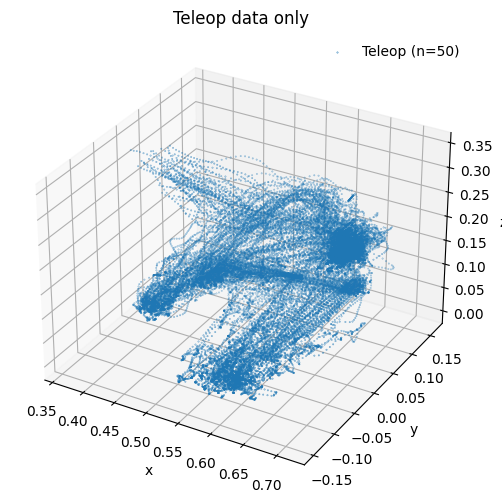

In [30]:
fig = plt.figure(figsize=(6, 6))

# Add a subplot for teleop data in the left side of the figure
ax1 = fig.add_subplot(111, projection="3d")

ax1.scatter(*pos_teleop.T, label=f"Teleop (n={len(ends_teleop)})", s=0.1)

ax1.legend(frameon=False)
ax1.set_title("Teleop data only")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

plt.show()

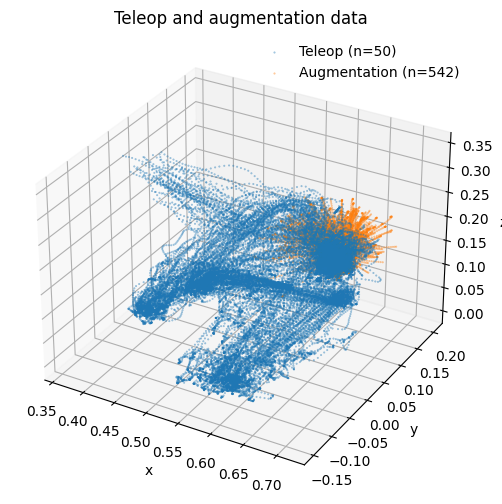

In [31]:
fig = plt.figure(figsize=(6, 6))

# Add a subplot for augmentation data in the right side of the figure
ax2 = fig.add_subplot(
    111, projection="3d"
)  # Changed from 111 to 122 for a 1x2 grid, second position
ax2.scatter(*pos_teleop.T, label=f"Teleop (n={len(ends_teleop)})", s=0.2, alpha=0.5)
ax2.scatter(*pos_aug.T, label=f"Augmentation (n={len(ends_aug)})", s=0.2, alpha=0.5)
ax2.legend(frameon=False)
ax2.set_title("Teleop and augmentation data")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")

plt.savefig("teleop_augmentation.pdf")

plt.show()

## Analyze the `square_table` augmentation

In [32]:
from pathlib import Path
from src.visualization.render_mp4 import (
    mp4_from_pickle_jupyter,
    unpickle_data,
    pickle_data,
)
from src.common.files import get_raw_paths
import random
from tqdm import tqdm

In [33]:
paths = get_raw_paths(
    environment="sim",
    demo_source="augmentation",
    demo_outcome="success",
    task="square_table",
    randomness="low",
)

random.shuffle(paths)

len(paths), paths[:3]

Found the following paths:
    /data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/square_table/augmentation/low/success/*.pkl*


(258,
 [PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/square_table/augmentation/low/success/2024-02-20T16:08:18.pkl.xz'),
  PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/square_table/augmentation/low/success/2024-02-20T13:24:36.pkl.xz'),
  PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/square_table/augmentation/low/success/2024-02-20T14:22:16.pkl.xz')])

In [35]:
for path in paths[:5]:
    mp4_from_pickle_jupyter(path, filename=path.stem + ".mp4", fps=20)

File saved as 2024-02-20T16:08:18.pkl.mp4


File saved as 2024-02-20T13:24:36.pkl.mp4


File saved as 2024-02-20T14:22:16.pkl.mp4


File saved as 2024-02-20T16:51:46.pkl.mp4


File saved as 2024-02-19T22:12:14.pkl.mp4


File saved as 2024-02-20T12:30:38.pkl.mp4


File saved as 2024-02-20T14:51:58.pkl.mp4


File saved as 2024-02-20T15:32:24.pkl.mp4


File saved as 2024-02-20T11:59:20.pkl.mp4


File saved as 2024-02-19T22:04:52.pkl.mp4


In [36]:
# One-off fix a mislabeled file
file = None
data = unpickle_data(file)
del data["augment_states"]
pickle_data(data, file)

TypeError: expected str, bytes or os.PathLike object, not NoneType

### Plot coverage of new trajectories

In [ ]:
import zarr
import matplotlib.pyplot as plt
import numpy as np


from src.common.files import get_processed_paths

In [ ]:
aug_path, teleop_path = sorted(
    get_processed_paths(
        environment="sim",
        demo_source=["teleop", "augmentation"],
        demo_outcome="success",
        task="square_table",
        randomness="low",
    )
)

aug_path, teleop_path

Found the following paths:
    /data/scratch/ankile/furniture-data/processed/sim/lamp/teleop/low/success.zarr
    /data/scratch/ankile/furniture-data/processed/sim/lamp/augmentation/low/success.zarr


(PosixPath('/data/scratch/ankile/furniture-data/processed/sim/lamp/augmentation/low/success.zarr'),
 PosixPath('/data/scratch/ankile/furniture-data/processed/sim/lamp/teleop/low/success.zarr'))

In [ ]:
z_aug = zarr.open(str(aug_path), mode="r")
z_teleop = zarr.open(str(teleop_path), mode="r")

ends_aug = z_aug["episode_ends"][:]
ends_teleop = z_teleop["episode_ends"][:]

pos_teleop = z_teleop["robot_state"][:, :3]
pos_aug = z_aug["robot_state"][:, :3]

# Split the data into episodes
pos_teleop = np.split(pos_teleop, ends_teleop[:-1])
pos_aug = np.split(pos_aug, ends_aug[:-1])

# # Get the skill labels for the teleop data and split them into episodes
# skill_teleop = z_teleop["critical"][:]
# skill_teleop = np.split(skill_teleop, ends_teleop[:-1])

# # For the teleop data, we slice off the data after the insertion
# pos_teleop = [
#     ep[: np.where(skill == 1)[0][3] + 1] for ep, skill in zip(pos_teleop, skill_teleop)
# ]

# # Concat them together again
pos_teleop = np.concatenate(pos_teleop)
pos_aug = np.concatenate(pos_aug)

In [ ]:
len(ends_teleop), len(pos_teleop), len(ends_aug), len(pos_aug)

(63, 53584, 286, 15378)

In [ ]:
# Sample a subset of the data
idx = np.random.choice(len(pos_teleop), size=53584, replace=False)
pos_teleop = pos_teleop[idx]

### Plot the state-space coverage in 3D

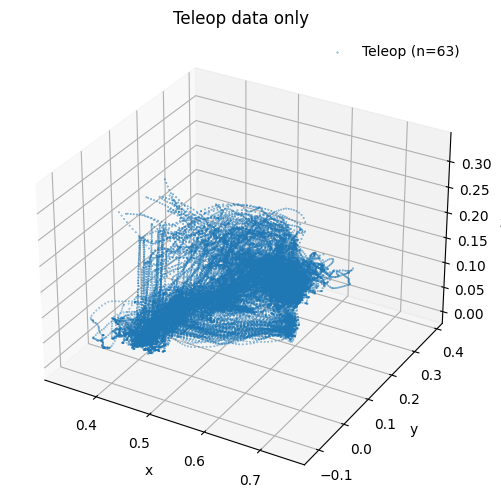

In [ ]:
fig = plt.figure(figsize=(6, 6))

# Add a subplot for teleop data in the left side of the figure
ax1 = fig.add_subplot(111, projection="3d")

ax1.scatter(*pos_teleop.T, label=f"Teleop (n={len(ends_teleop)})", s=0.1)

ax1.legend(frameon=False)
ax1.set_title("Teleop data only")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

plt.show()

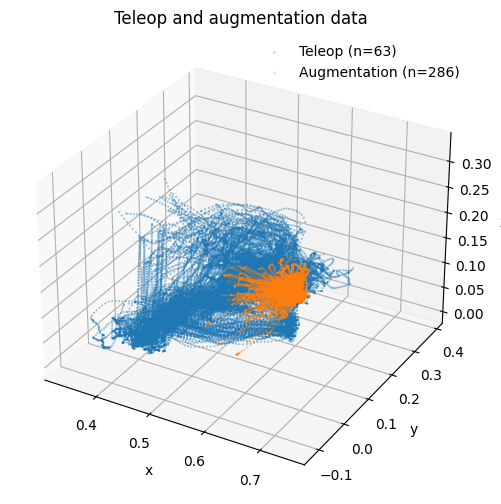

In [ ]:
fig = plt.figure(figsize=(6, 6))

# Add a subplot for augmentation data in the right side of the figure
ax2 = fig.add_subplot(
    111, projection="3d"
)  # Changed from 111 to 122 for a 1x2 grid, second position
ax2.scatter(*pos_teleop.T, label=f"Teleop (n={len(ends_teleop)})", s=0.2, alpha=0.5)
ax2.scatter(*pos_aug.T, label=f"Augmentation (n={len(ends_aug)})", s=0.2, alpha=0.5)
ax2.legend(frameon=False)
ax2.set_title("Teleop and augmentation data")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")

plt.savefig("teleop_augmentation.pdf")

plt.show()

In [ ]:
from pathlib import Path
from src.visualization.render_mp4 import (
    mp4_from_pickle_jupyter,
    unpickle_data,
    pickle_data,
)
from src.common.files import get_raw_paths
import random
from tqdm import tqdm

In [ ]:
paths = get_raw_paths(
    environment="sim",
    demo_source="teleop",
    demo_outcome="success",
    task="square_table",
    randomness="low",
)

random.shuffle(paths)

len(paths), paths[:3]

Found the following paths:
    /data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/square_table/teleop/low/success/*.pkl*


(50,
 [PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/square_table/teleop/low/success/2024-02-19T21:24:13.pkl'),
  PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/square_table/teleop/low/success/2024-02-19T21:01:58.pkl'),
  PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/square_table/teleop/low/success/2024-02-19T09:21:51.pkl')])

In [ ]:
for p in tqdm(paths):
    path = Path(p)
    try:
        data = unpickle_data(path)
    except EOFError:
        print(f"Failed to load {path}")

  0%|          | 0/50 [00:22<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
for path in paths[:5]:
    mp4_from_pickle_jupyter(path, filename=path.stem + ".mp4", fps=20)

File saved as 2024-02-19T21:24:13.mp4


File saved as 2024-02-19T21:01:58.mp4


File saved as 2024-02-19T09:21:51.mp4


File saved as 2024-02-19T12:02:09.mp4


File saved as 2024-02-19T20:58:08.mp4
